<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Santiago/1_Baseline_Notebook_Exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedPerf - Baseline notebook for experiments

## Setup & Dependencies Installation

In [ ]:
!pip install torchsummaryX

In [ ]:
%load_ext tensorboard

import copy
from functools import reduce
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import Sampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchsummaryX import summary as summaryx
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm

%matplotlib inline

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
RANDOM_SEED = 42

# general reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Fri Apr 23 12:41:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading Datasets

In [ ]:
!rm -Rf data
!mkdir -p data scripts

### MNIST

In [ ]:
transforms_mnist = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
# Commented as it throws a `HTTP Error 503: Service Unavailable` error
# mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
# mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

In [ ]:
# Run this if the above cell is still throwing a 503 error
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz -O data/MNIST.tar.gz
!tar -zxvf ./data/MNIST.tar.gz -C data/

--2021-04-16 13:33:40--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-16 13:33:41--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘data/MNIST.tar.gz’

data/MNIST.tar.gz       [            <=>     ]  33.20M  13.9MB/s    in 2.4s    

2021-04-16 13:33:44 (13.9 MB/s) - ‘data/MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNI

In [ ]:
# Run this if the above cell is still throwing a 503 error
mnist_data_train = datasets.MNIST(root='./data', train=True, download=False, transform=transforms_mnist)
mnist_data_test = datasets.MNIST(root='./data', train=False, download=False, transform=transforms_mnist)

In [ ]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))

Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [ ]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


In [ ]:
# dl = DataLoader(mnist_data_train, batch_size=10)
# for t, l in dl:
#     print(t.shape, l.shape)
#     break

### CIFAR

In [ ]:
# transforms_cifar10 = transforms.Compose([transforms.ToTensor(),
#                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                          ])

# cifar10_data_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
# cifar10_data_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)

In [ ]:
# classes = np.array(list(cifar10_data_train.class_to_idx.values()))
# classes_test = np.array(list(cifar10_data_test.class_to_idx.values()))
# num_classes = len(classes_test)
# print("Classes: {} \tType: {}".format(classes, type(classes)))
# print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))

In [ ]:
# print("Image Shape: {}".format(cifar10_data_train.data[0].shape))

### Shakespeare

In [ ]:
GENERATE_DATASET = False  # If False, download the dataset provided by the q-FFL paper
DATA_DIR = 'data/'
# Dataset generation params
SAMPLES_FRACTION = 1.
# SAMPLES_FRACTION = 0.2  # Fraction of total samples in the dataset - FedProx default script?
# SAMPLES_FRACTION = 0.05  # Fraction of total samples in the dataset
TRAIN_FRACTION = 0.8  # Train set size
MIN_SAMPLES = 0  # Min samples per client (for filtering purposes) - FedProx
# MIN_SAMPLES = 64  # Min samples per client (for filtering purposes) - qFFL

In [ ]:
# Download raw dataset
# !wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt -O data/shakespeare.txt
!wget --adjust-extension http://www.gutenberg.org/files/100/100-0.txt -O data/shakespeare.txt

--2021-04-23 12:41:39--  http://www.gutenberg.org/files/100/100-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5757108 (5.5M) [text/plain]
Saving to: ‘data/shakespeare.txt’

data/shakespeare.tx 100%[===================>]   5.49M  26.9MB/s    in 0.2s    

2021-04-23 12:41:39 (26.9 MB/s) - ‘data/shakespeare.txt’ saved [5757108/5757108]



In [ ]:
if not GENERATE_DATASET:
    !rm -Rf data/train data/test
    !gdown --id 1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD  # Download Shakespeare dataset used by the FedProx paper
    !unzip shakespeare.zip
    !mv -f shakespeare_paper/train data/
    !mv -f shakespeare_paper/test data/
    !rm -R shakespeare_paper/ shakespeare.zip


Downloading...
From: https://drive.google.com/uc?id=1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD
To: /content/shakespeare.zip
2.96MB [00:00, 94.7MB/s]
Archive:  shakespeare.zip
   creating: shakespeare_paper/
   creating: shakespeare_paper/test/
  inflating: shakespeare_paper/test/all_data_niid_2_keep_0_test_8.json  
   creating: shakespeare_paper/train/
  inflating: shakespeare_paper/train/all_data_niid_2_keep_0_train_8.json  


#### Dataset Preprocessing script

In [ ]:
%%capture
!pip install unidecode

In [ ]:
from unidecode import unidecode

In [ ]:
corpus = []
with open('data/shakespeare.txt', 'r') as f:
    data = list(unidecode(f.read()))
    corpus = list(set(list(data)))
print('Corpus Length:', len(corpus))

Corpus Length: 90


In [ ]:
%%capture
if GENERATE_DATASET:
    # Download dataset generation scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/preprocess_shakespeare.py -O scripts/preprocess_shakespeare.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/shake_utils.py -O scripts/shake_utils.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/gen_all_data.py -O scripts/gen_all_data.py

    # Download data preprocessing scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/sample.py -O scripts/sample.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/remove_users.py -O scripts/remove_users.py

In [ ]:
# Running scripts
if GENERATE_DATASET:
    !mkdir -p data/raw_data data/all_data data/train data/test
    !python scripts/preprocess_shakespeare.py data/shakespeare.txt data/raw_data
    !python scripts/gen_all_data.py

##### Dataset split script

In [ ]:
if GENERATE_DATASET:
    subdir = 'data/all_data'
    files = [f for f in os.listdir(subdir) if f.endswith('.json')]

    for f in files:
        print('Processing -> {}'.format(f))
        include_hierarchy = False
        file_dir = os.path.join(subdir, f)
        with open(file_dir, 'r') as file:
            data = json.load(file)

        users = data['users']
        num_users = len(users)
        tot_num_samples = sum(data['num_samples'])
        print('Fraction: ', SAMPLES_FRACTION)
        num_new_samples = int(SAMPLES_FRACTION * tot_num_samples)

        hierarchies = None

        ctot_num_samples = 0

        users_and_hiers = None
        if 'hierarchies' in data:
            include_hierarchy = True
            users_and_hiers = list(zip(users, data['hierarchies']))
            random.shuffle(users_and_hiers)
        else:
            random.shuffle(users)

        user_i = 0
        num_samples = []
        user_data = {}

        if include_hierarchy:
            hierarchies = []

        users_subset = [] # subsample users

        while ctot_num_samples < num_new_samples and user_i < num_users:
            hierarchy = None
            if users_and_hiers is not None:
                user, hier = users_and_hiers[user_i]
            else:
                user = users[user_i]

            cdata = data['user_data'][user]

            cnum_samples = len(data['user_data'][user]['y'])

            if cnum_samples > MIN_SAMPLES:

                if (ctot_num_samples + cnum_samples > num_new_samples):
                    cnum_samples = num_new_samples - ctot_num_samples
                    indices = list(range(cnum_samples))
                    new_indices = random.sample(indices, cnum_samples)
                    x, y = [], []
                    for i in new_indices:
                        x.append(data['user_data'][user]['x'][i])
                        y.append(data['user_data'][user]['y'][i])
                    cdata = {'x': x, 'y': y}
                
                if include_hierarchy:
                    hierarchies.append(hier)

                num_samples.append(cnum_samples)
                user_data[user] = cdata

                ctot_num_samples += cnum_samples

                users_subset.append(user)

            user_i += 1

        # ------------
        # create .json file

        all_data = {}
        all_data['users'] = users_subset
        if include_hierarchy:
            all_data['hierarchies'] = hierarchies
        all_data['num_samples'] = num_samples
        all_data['user_data'] = user_data

        #########################################

        # Split data for train/test
        num_samples_train, num_samples_test = [], []
        user_data_train, user_data_test = {}, {}

        user_indices = [] # indices of users in all_data['users'] that are not deleted

        for i, u in enumerate(all_data['users']):
            user_data_train[u] = {'x': [], 'y': []}
            user_data_test[u] = {'x': [], 'y': []}

            curr_num_samples = len(all_data['user_data'][u]['y'])
            if curr_num_samples >= 2:
                user_indices.append(i)
                # ensures number of train and test samples both >= 1
                num_train_samples = max(1, int(TRAIN_FRACTION * curr_num_samples))
                if curr_num_samples == 2:
                    num_train_samples = 1

                num_test_samples = curr_num_samples - num_train_samples
                num_samples_train.append(num_train_samples)
                num_samples_test.append(num_test_samples)

                indices = list(range(curr_num_samples))
                train_indices = random.sample(indices, num_train_samples)
                train_blist = [False for _ in range(curr_num_samples)]
                for j in train_indices:
                    train_blist[j] = True

                for j in range(curr_num_samples):
                    if (train_blist[j]):
                        user_data_train[u]['x'].append(all_data['user_data'][u]['x'][j])
                        user_data_train[u]['y'].append(all_data['user_data'][u]['y'][j])
                    else:
                        user_data_test[u]['x'].append(all_data['user_data'][u]['x'][j])
                        user_data_test[u]['y'].append(all_data['user_data'][u]['y'][j])

        users = [all_data['users'][i] for i in user_indices]

        all_data_train = {}
        all_data_train['users'] = users
        all_data_train['num_samples'] = num_samples_train
        all_data_train['user_data'] = user_data_train
        all_data_test = {}
        all_data_test['users'] = users
        all_data_test['num_samples'] = num_samples_test
        all_data_test['user_data'] = user_data_test

        if include_hierarchy:
            all_data_train['hierarchies'] = all_data['hierarchies']
            all_data_test['hierarchies'] = all_data['hierarchies']

        slabel = 'niid'
        arg_frac = str(SAMPLES_FRACTION)[2:]
        arg_label = f'{slabel}_{arg_frac}_keep_{MIN_SAMPLES}'

        file_name_train = '%s_niid_%s_train_%s.json' % ((f[:-5]), arg_label, str(TRAIN_FRACTION)[2:])
        file_name_test = '%s_niid_%s_test_%s.json' % ((f[:-5]), arg_label, str(round(1. - TRAIN_FRACTION, 1))[2:])
        ouf_dir_train = os.path.join(DATA_DIR, 'train', file_name_train)
        ouf_dir_test = os.path.join(DATA_DIR, 'test', file_name_test)
        print('writing %s' % file_name_train)
        with open(ouf_dir_train, 'w') as outfile:
            json.dump(all_data_train, outfile)
        print('writing %s' % file_name_test)
        with open(ouf_dir_test, 'w') as outfile:
            json.dump(all_data_test, outfile)


#### Dataset class

##### Centralized (IID) dataset

In [ ]:
class RandomSequentialSampler(Sampler):
    def __init__(self, datasource, seq_count):
        self.source = datasource
        self.seq_count = seq_count

    def __iter__(self):
        flatten = lambda l: [item for sublist in l for item in sublist]
        groups = [[(i, i + self.seq_count)] for i in range(0, len(self), self.seq_count)]
        random.shuffle(groups)
        groups = flatten(groups)
        return iter(groups)

    def __len__(self):
        return len(self.source) - self.seq_count


class ShakespeareIIDDataset(Dataset):
    def __init__(self, fname='./data/shakespeare.txt'):
        super(ShakespeareIIDDataset, self).__init__()

        self.data = ''
        self.corpus = []
        with open(fname, 'r') as f:
            self.data = list(unidecode(f.read()))
            self.corpus = list(set(list(self.data)))

    def __len__(self):
        return len(self.data) - 1

    def __repr__(self):
        return f'{self.__class__} - (length: {self.__len__()})'

    def __getitem__(self, i):
        input_seq = self.data[slice(*i)]
        next_char = self.data[i[1] + 1]
        input_value = self.text2charindxs(input_seq)
        target_value = self.get_label_from_char(next_char)
        
        return input_value, target_value

    def text2charindxs(self, text):
        tensor = torch.zeros(len(text), dtype=torch.int32)
        for i, c in enumerate(text):
            tensor[i] = self.get_label_from_char(c)
        return tensor

    def dataloader(self, seq_count, batch_size):
        return DataLoader(self,
                          sampler=RandomSequentialSampler(self, seq_count),
                          batch_size=batch_size,
                          pin_memory=torch.cuda.is_available(),
                          num_workers=0)

    def get_label_from_char(self, c):
        return self.corpus.index(c)

    def get_char_from_label(self, l):
        return self.corpus[l]

In [ ]:
# # Test
# shakespeare_ds = ShakespeareIIDDataset()
# print(len(shakespeare_ds.corpus), len(shakespeare_ds))

# dl = shakespeare_ds.dataloader(80, 10)
# print(len(dl))

# for s in dl:
#     print(len(s))
#     print(s[0].shape, s[1].shape)
#     break

##### Federated Dataset

In [ ]:
# import string
# string.printable

In [ ]:
# CHAR_CORPORA = "\n !\"&'(),-.0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz}"
# ",".join([c for c in corpus if c not in CHAR_CORPORA])

In [ ]:
class ShakespeareDataset(Dataset):
    def __init__(self, x, y, corpus, seq_length):
        super(ShakespeareDataset, self).__init__()
        self.x = x
        self.y = y
        self.corpus = corpus
        self.corpus_size = len(self.corpus)

    def __len__(self):
        return len(self.x)

    def __repr__(self):
        return f'{self.__class__} - (length: {self.__len__()})'

    def __getitem__(self, i):
        input_seq = self.x[i]
        next_char = self.y[i]
        # print('\tgetitem', i, input_seq, next_char)
        input_value = self.text2charindxs(input_seq)
        target_value = self.get_label_from_char(next_char)
        return input_value, target_value

    def text2charindxs(self, text):
        tensor = torch.zeros(len(text), dtype=torch.int32)
        for i, c in enumerate(text):
            tensor[i] = self.get_label_from_char(c)
        return tensor

    def get_label_from_char(self, c):
        return self.corpus.index(c)

    def get_char_from_label(self, l):
        return self.corpus[l]

In [ ]:
class ShakespeareFedDataset(ShakespeareDataset):
    def __init__(self, x, y, corpus, seq_length):
        super(ShakespeareFedDataset, self).__init__(x, y, corpus, seq_length)

    def dataloader(self, batch_size, shuffle=True):
        return DataLoader(self,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          num_workers=0)


In [ ]:
# # TEST
# train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
# with open(train_file, 'r') as file:
#     data_train = json.loads(unidecode(file.read()))
# x = data_train['user_data'][data_train['users'][0]]['x']
# y = data_train['user_data'][data_train['users'][0]]['y']
# shakespeare_ds = ShakespeareFedDataset(x, y, corpus=corpus, seq_length=80)
# print(len(shakespeare_ds))

# dl = shakespeare_ds.dataloader(15)
# print(len(dl))

# for s in dl:
#     print(len(s))
#     print(s[0].shape, s[1].shape)
#     break

## Partitioning & Data Loaders

### IID

In [ ]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

#### Shakespeare

In [ ]:
def shakespeare_iid_partition(corpus, seq_length=80, val_split=False):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.loads(unidecode(file.read()))

    with open(test_file, 'r') as file:
        data_test = json.loads(unidecode(file.read()))

    
    total_samples_train = sum(data_train['num_samples'])

    data_dict = {}

    x_train, y_train = [], []
    x_test, y_test = [], []
    # x_val, y_val = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)



    total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    print('Objective', total_samples, '/', sum(data_train['num_samples']))
    sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        if sample_count >= total_samples:
            print('Max samples reached', sample_count, '/', total_samples)
            break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            max_samples = samples if (sample_count + samples) <= total_samples else (sample_count + samples - total_samples) 
            
            sample_count += max_samples
            # print('sample_count', sample_count)

            x_train.extend(data_train['user_data'][author_id]['x'][:max_samples])
            y_train.extend(data_train['user_data'][author_id]['y'][:max_samples])

            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)

            if val_split:
                x_test.extend(author_data['x'][:int(test_size / 2)])
                y_test.extend(author_data['y'][:int(test_size / 2)])
                # x_val.extend(author_data['x'][int(test_size / 2):])
                # y_val.extend(author_data['y'][int(test_size / 2):int(test_size)])

            else:
                x_test.extend(author_data['x'][:int(test_size)])
                y_test.extend(author_data['y'][:int(test_size)])

    train_ds = ShakespeareDataset(x_train, y_train, corpus, seq_length)
    test_ds = ShakespeareDataset(x_test, y_test, corpus, seq_length)
    # val_ds = ShakespeareDataset(x_val, y_val, corpus, seq_length)

    data_dict = iid_partition_(train_ds, clients=len(users))

    return train_ds, data_dict, test_ds

### Non-IID

#### MNIST

In [ ]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

#### Shakespeare

In [ ]:
def shakespeare_noniid_partition(corpus, seq_length=80, val_split=True):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.loads(unidecode(file.read()))

    with open(test_file, 'r') as file:
        data_test = json.loads(unidecode(file.read()))

    
    total_samples_train = sum(data_train['num_samples'])

    data_dict = {}

    x_test, y_test = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)

    total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    print('Objective', total_samples, '/', sum(data_train['num_samples']))
    sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        if sample_count >= total_samples:
            print('Max samples reached', sample_count, '/', total_samples)
            break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            max_samples = samples if (sample_count + samples) <= total_samples else (sample_count + samples - total_samples) 
            
            sample_count += max_samples
            print('sample_count', sample_count)

            x_train = data_train['user_data'][author_id]['x'][:max_samples]
            y_train = data_train['user_data'][author_id]['y'][:max_samples]

            train_ds = ShakespeareFedDataset(x_train, y_train, corpus, seq_length)

            x_val, y_val = None, None
            val_ds = None
            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)
            if val_split:
                x_test += author_data['x'][:int(test_size / 2)]
                y_test += author_data['y'][:int(test_size / 2)]
                x_val = author_data['x'][int(test_size / 2):]
                y_val = author_data['y'][int(test_size / 2):int(test_size)]

                val_ds = ShakespeareFedDataset(x_val, y_val, corpus, seq_length)

            else:
                x_test += author_data['x'][:int(test_size)]
                y_test += author_data['y'][:int(test_size)]

            data_dict[author_id] = {
                'train_ds': train_ds,
                'val_ds': val_ds
            }

    test_ds = ShakespeareFedDataset(x_test, y_test, corpus, seq_length)

    return data_dict, test_ds

## Models

### MNIST CNN

In [ ]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

#### Model Summary

In [ ]:
# mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
#   mnist_mlp.cuda()
  mnist_cnn.cuda()

# print("MNIST MLP SUMMARY")
# print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))


MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264
         MaxPool2d-4             [-1, 64, 4, 4]               0
           Dropout-5             [-1, 64, 4, 4]               0
            Linear-6                  [-1, 512]         524,800
            Linear-7                   [-1, 10]           5,130
Total params: 582,026
Trainable params: 582,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 2.22
Estimated Total Size (MB): 2.45
----------------------------------------------------------------
None


### Shakespeare LSTM

In [ ]:
class ShakespeareLSTM(nn.Module):
    """
    """

    def __init__(self, input_dim, embedding_dim, hidden_dim, classes, lstm_layers=2, dropout=0.1, batch_first=True):
        super(ShakespeareLSTM, self).__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.classes = classes
        self.no_layers = lstm_layers
        
        self.embedding = nn.Embedding(num_embeddings=self.classes,
                                      embedding_dim=self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, 
                            hidden_size=self.hidden_dim,
                            num_layers=self.no_layers,
                            batch_first=batch_first, 
                            dropout=dropout if self.no_layers > 1 else 0.)
        self.fc = nn.Linear(hidden_dim, self.classes)

    def forward(self, x, hc=None):
        batch_size = x.size(0)
        x_emb = self.embedding(x)
        out, (ht, ct) = self.lstm(x_emb.view(batch_size, -1, self.embedding_dim), hc)
        dense = self.fc(ht[-1])
        return dense
    
    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(self.no_layers, batch_size, self.hidden_dim)),
                Variable(torch.zeros(self.no_layers, batch_size, self.hidden_dim)))


#### Model Summary

In [ ]:
batch_size = 10
seq_length = 80 # mcmahan17a, fedprox, qFFL

shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=8,  # mcmahan17a, fedprox, qFFL
                                   hidden_dim=256,  # mcmahan17a, fedprox impl
                                #    hidden_dim=100,  # fedprox paper
                                   classes=len(corpus),
                                   lstm_layers=2,
                                   dropout=0.1,  # TODO:
                                   batch_first=True
                                   )

if torch.cuda.is_available():
  shakespeare_lstm.cuda()



hc = shakespeare_lstm.init_hidden(batch_size)

x_sample = torch.zeros((batch_size, seq_length),
                       dtype=torch.long,
                       device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')))

x_sample[0][0] = 1
x_sample

print("\nShakespeare LSTM SUMMARY")
print(summaryx(shakespeare_lstm, x_sample))


Shakespeare LSTM SUMMARY
dense torch.Size([10, 90])
            Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                     
0_embedding      [8, 90]    [10, 80, 8]     720        720
1_lstm                 -  [10, 80, 256]  798720     794624
2_fc           [256, 90]       [10, 90]   23130      23040
----------------------------------------------------------
                      Totals
Total params          822570
Trainable params      822570
Non-trainable params       0
Mult-Adds             818384
            Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                     
0_embedding      [8, 90]    [10, 80, 8]     720        720
1_lstm                 -  [10, 80, 256]  798720     794624
2_fc           [256, 90]       [10, 90]   23130      23040


## Algorithms

### Utils

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def plot_scores(history, file='test_scores.jpg'):
    accuracies = [x['accuracy'] for x in history]
    f1_macro = [x['f1_macro'] for x in history]
    f1_weighted = [x['f1_weighted'] for x in history]

    fig, ax = plt.subplots()

    ax.plot(accuracies, '-x', label='Valid Acc')
    ax.plot(f1_macro, '-x', label='F1 (macro)')
    ax.plot(f1_weighted, '-x', label='F1 (weighted)')
    ax.set(xlabel='epoch', ylabel='score', title='Score vs. No. of epochs')
    ax.legend();

    fig.savefig(file, format='jpg')


def plot_losses(history, file='test_loss.jpg'):
    val_losses = [x['loss'] for x in history]

    fig, ax = plt.subplots()

    ax.plot(val_losses, '-rx')
    ax.set(xlabel='epoch', ylabel='loss', title='Loss vs. No. of epochs')
    ax.legend(['Validation'])

    fig.savefig(file, format='jpg')


### FedAvg

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

In [ ]:
# TODO

### FedProx

#### Systems Heterogeneity Simulations

Generate epochs for selected clients based on percentage of devices that corresponds to heterogeneity. 

Assign x number of epochs (chosen unifirmly at random between [1, E]) to 0%, 50% or 90% of the selected devices, respectively. Settings where 0% devices perform fewer than E epochs of work correspond to the environments without system heterogeneity, while 90% of the devices sending their partial solutions corresponds to highly heterogenous system.

In [ ]:
def GenerateLocalEpochs(percentage, size, max_epochs):
  ''' Method generates list of epochs for selected clients
  to replicate system heteroggeneity

  Params:
    percentage: percentage of clients to have fewer than E epochs
    size:       total size of the list
    max_epochs: maximum value for local epochs
  
  Returns:
    List of size epochs for each Client Update

  '''

  # if percentage is 0 then each client runs for E epochs
  if percentage == 0:
      return np.array([max_epochs]*size)
  else:
    # get the number of clients to have fewer than E epochs
    heterogenous_size = int((percentage/100) * size)

    # generate random uniform epochs of heterogenous size between 1 and E
    epoch_list = np.random.randint(1, max_epochs, heterogenous_size)

    # the rest of the clients will have E epochs
    remaining_size = size - heterogenous_size
    rem_list = [max_epochs]*remaining_size

    epoch_list = np.append(epoch_list, rem_list, axis=0)
    
    # shuffle the list and return
    np.random.shuffle(epoch_list)

    return epoch_list

#### Local Training (Client Update)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

In [ ]:
class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs, mu, algorithm):
    # self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.algorithm = algorithm
    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):
    # print("Client training for {} epochs.".format(self.epochs))
    criterion = nn.CrossEntropyLoss()
    proximal_criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    # use the weights of global model for proximal term calculation
    global_model = copy.deepcopy(model)

    # calculate local training time
    start_time = time.time()


    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)

        # calculate the loss + the proximal term
        _, pred = torch.max(output, 1)

        if self.algorithm == 'fedprox':
          proximal_term = 0.0

          # iterate through the current and global model parameters
          for w, w_t in zip(model.parameters(), global_model.parameters()) :
            # update the proximal term 
            #proximal_term += torch.sum(torch.abs((w-w_t)**2))
            proximal_term += (w-w_t).norm(2)

          loss = criterion(output, labels) + (mu/2)*proximal_term
        else:
          loss = criterion(output, labels)
    
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss, (time.time() - start_time)

#### Server Side Training

In [ ]:
def training(model, rounds, batch_size, lr, ds, data_dict, test_ds, C, K, E, mu, percentage, plt_title, plt_color, target_test_accuracy,
             classes, algorithm="fedprox", history=[], eval_every=1, tb_logger=None):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - test_data_dict:  Data used for testing the model
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - mu:              proximal term constant
    - percentage:      percentage of selected client to have fewer than E epochs
  Returns:
    - model:           Trained model on the server
  """

  start = time.time()

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # test accuracy
  test_acc = []

  # store last loss for convergence
  last_loss = 0.0

  # total time taken 
  total_time = 0

  print(f"System heterogeneity set to {percentage}% stragglers.\n")
  print(f"Picking {max(int(C*K),1 )} random clients per round.\n")

  users_id = list(data_dict.keys())

  for curr_round in range(1, rounds+1):
    w, local_loss, lst_local_train_time = [], [], []

    m = max(int(C*K), 1)

    heterogenous_epoch_list = GenerateLocalEpochs(percentage, size=m, max_epochs=E)
    heterogenous_epoch_list = np.array(heterogenous_epoch_list)
    # print('heterogenous_epoch_list', len(heterogenous_epoch_list))

    S_t = np.random.choice(range(K), m, replace=False)
    S_t = np.array(S_t)
    print('Clients: {}/{} -> {}'.format(len(S_t), K, S_t))
    
    # For Federated Averaging, drop all the clients that are stragglers
    if algorithm == 'fedavg':
      stragglers_indices = np.argwhere(heterogenous_epoch_list < E)
      heterogenous_epoch_list = np.delete(heterogenous_epoch_list, stragglers_indices)
      S_t = np.delete(S_t, stragglers_indices)

    # for _, (k, epoch) in tqdm(enumerate(zip(S_t, heterogenous_epoch_list))):
    for i in tqdm(range(len(S_t))):
    #   print('k', k)
      k = S_t[i]
      epoch = heterogenous_epoch_list[i]
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
    #   print(f'Client {k}: {len(idxs) if idxs else len(ds_)} samples:')
      local_update = ClientUpdate(dataset=ds_, batchSize=batch_size, learning_rate=lr, epochs=epoch, idxs=idxs, mu=mu, algorithm=algorithm)
      weights, loss, local_train_time = local_update.train(model=copy.deepcopy(model))
    #   print(f'Local train time for {k} on {len(idxs) if idxs else len(ds_)} samples: {local_train_time}')
    #   print(f'Local train time: {local_train_time}')

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      lst_local_train_time.append(local_train_time)

    # calculate time to update the global weights
    global_start_time = time.time()

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    global_end_time = time.time()

    # calculate total time 
    total_time += (global_end_time - global_start_time) + sum(lst_local_train_time)/len(lst_local_train_time)

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)
    if tb_logger:
        tb_logger.add_scalar(f'Train/Loss', loss_avg, curr_round)

    # testing
    # if curr_round % eval_every == 0:
    test_scores = testing(model, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(classes), classes)
    history.append(test_scores)
    test_loss, test_accuracy = test_scores['loss'], test_scores['accuracy']
    
    # print('Round: {}... \tAverage Loss: {} \tTest Loss: {} \tTest Acc: {}'.format(curr_round, round(loss_avg, 3), round(test_loss, 3), round(test_accuracy, 3)))

    if tb_logger:
        tb_logger.add_scalar(f'Test/Loss', test_scores['loss'], curr_round)
        tb_logger.add_scalars(f'Test/Scores', {
            'accuracy': test_scores['accuracy'], 'f1_macro': test_scores['f1_macro'], 'f1_weighted': test_scores['f1_weighted']
        }, curr_round)

    test_acc.append(test_accuracy)
    # break if we achieve the target test accuracy
    if test_accuracy >= target_test_accuracy:
      rounds = curr_round
      break

    # break if we achieve convergence, i.e., loss between two consecutive rounds is <0.0001
    if algorithm == 'fedprox' and abs(loss_avg - last_loss) < 0.0001:
      rounds = curr_round
      break
    
    # update the last loss
    last_loss = loss_avg

  end = time.time()
  # plot train loss
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'.jpg', format='jpg')

  # plot test accuracy
  fig1, ax1 = plt.subplots()
  x_axis1 = np.arange(1, rounds+1)
  y_axis1 = np.array(test_acc)
  ax1.plot(x_axis1, y_axis1)

  ax1.set(xlabel='Number of Rounds', ylabel='Test Accuracy', title=plt_title)
  ax1.grid()
  fig1.savefig(plt_title+'-test.jpg', format='jpg')
  
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  # print("Total time taken to Train: {}".format(get_time_format(total_time)))

  return model, history

#### Testing Loop

In [ ]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_all=False):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  print('running validation...')
  for i, (data, labels) in enumerate(tqdm(test_loader)):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    # for i in range(num_classes):
    #   label = labels.data[i]
    #   correct_class[label] += correct[i].item()
    #   total_class[label] += 1

    for i, lbl in enumerate(labels.data):
    #   print('lbl', i, lbl)
      correct_class[lbl] += correct.data[i]
      total_class[lbl] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  if print_all:
    for i in range(num_classes):
        if total_class[i]>0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
                    (classes[i], 100 * correct_class[i] / total_class[i],
                    np.sum(correct_class[i]), np.sum(total_class[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

#   test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)
  overall_accuracy = np.sum(correct_class) / np.sum(total_class)

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(overall_accuracy, np.sum(correct_class), np.sum(total_class)))

  return {'loss': test_loss, 'accuracy': overall_accuracy, 'f1_macro': None, 'f1_weighted': None}

In [ ]:
# TODO

### qFedAvg

#### Local Training (Client update)

In [ ]:
class ClientUpdate(object):
  def __init__(self, dataset, batch_size, learning_rate, epochs, idxs, q=None):
    """

    """
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs
    self.q = q
    if not self.q:
        # TODO: Client itself adjust fairness 
        pass
    self.mu = 1e-10

  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    model_weights = copy.deepcopy(model.state_dict())
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      # for data, labels in tqdm(self.train_loader):
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        # print('input', data.size())
        output = model(data)
        # print('output', output.size())
        # print('labels', labels.size())
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)


    total_loss = sum(e_loss)/len(e_loss)

    # delta weights
    model_weights_new = copy.deepcopy(model.state_dict())
    L = 1.0 / self.learning_rate

    # delta_weights = torch.tensor([(u - v) * L for u, v in zip(model_weights, model_weights_new)],
    #                              device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')))
    # # delta = [np.float_power(total_loss + self.mu, self.q) * grad for grad in delta_weights]
    # delta = delta_weights * np.float_power(total_loss + self.mu, self.q)
    # # Estimation of the local Lipchitz constant
    # h = (self.q * np.float_power(total_loss + self.mu, self.q - 1) * torch.pow(torch.norm(delta_weights), 2)) + \
    #     (L * np.float_power(total_loss + self.mu, self.q))

    delta_weights, delta, h = {}, {}, {}
    loss_q = np.float_power(total_loss + self.mu, self.q)
    # updating the global weights
    for k in model_weights_new.keys():
      delta_weights[k] = (model_weights[k] - model_weights_new[k]) * L
      delta[k] =  loss_q * delta_weights[k]
      # Estimation of the local Lipchitz constant
      h[k] = (self.q * np.float_power(total_loss + self.mu, self.q - 1) * torch.pow(torch.norm(delta_weights[k]), 2)) + (L * loss_q)

    return delta, h, total_loss

#### Server Side Training

In [ ]:
def client_sampling(n, m, weights=None, with_replace=False):
    pk = None
    if weights:
        total_weights = np.sum(np.asarray(weights))
        pk = [w * 1.0 / total_weights for w in weights]

    return np.random.choice(range(n), m, replace=with_replace, p=pk)

In [ ]:
def training(model, rounds, batch_size, lr, ds, data_dict, test_ds, C, K, E, q=0, sampling='uniform', tb_logger=None, test_history=[], perf_fig_file='loss.jpg'):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - test_ds          Dataset used for global testing
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - q:               Parameter that tunes the amount of fairness we wish to impose (default: 0 -> vanilla FedAvg objective)
    - sampling         Uniform or weighted (default: uniform)
    - tb_logger:       Tensorboard SummaryWriter
    - test_history:    Test Scores history log
    - perf_fig_file    File for storing final performance plot (loss)
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # client weights by total samples
  p_k = None
  if sampling == 'weighted':
    p_k = [len(data_dict[c]) for c in data_dict] if ds else [len(data_dict[c]['train_ds']) for c in data_dict]

  # Time log
  start_time = time.time()

  users_id = list(data_dict.keys())

  # Orchestrate training
  for curr_round in range(1, rounds+1):
    deltas, hs, local_loss = [], [], []

    m = max(int(C*K), 1)    
    S_t = client_sampling(K, m, weights=p_k, with_replace=False)

    print('Round: {} Picking {}/{} clients: {}'.format(curr_round, m, K, S_t))

    global_weights = model.state_dict()

    for k in tqdm(S_t):
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
      local_update = ClientUpdate(dataset=ds_, batch_size=batch_size, learning_rate=lr, epochs=E, idxs=idxs, q=q)
    #   weights, loss = local_update.train(model=copy.deepcopy(model))
      delta_k, h_k, loss = local_update.train(model=copy.deepcopy(model))

      deltas.append(copy.deepcopy(delta_k))
      hs.append(copy.deepcopy(h_k))
      local_loss.append(copy.deepcopy(loss))

      if tb_logger:
        tb_logger.add_scalar(f'Round/S{k}', loss, curr_round)

    # Perform qFedAvg
    h_sum = copy.deepcopy(hs[0])
    delta_sum = copy.deepcopy(deltas[0])
    
    for k in h_sum.keys():
        for i in range(1, len(hs)):
            h_sum[k] += hs[i][k]
            delta_sum[k] += deltas[i][k]

    new_weights = {}
    for k in delta_sum.keys():
        for i in range(len(deltas)):
            new_weights[k] = delta_sum[k] / h_sum[k]

    # Updating global model weights
    for k in global_weights.keys():
        global_weights[k] -= new_weights[k]

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    if tb_logger:
        tb_logger.add_scalar('Train/Loss', loss_avg, curr_round)
        # tb_logger.add_scalar(f'Train/Datapoints', total_datapoints, curr_round)
    
    if curr_round % 5 == 0:
        test_scores = testing(model, test_ds, batch_size, nn.CrossEntropyLoss(), num_classes, list(range(num_classes)))
        # test_scores = testing(model, test_ds, val_batch_size, nn.CrossEntropyLoss(weight=avg_weights), num_classes, list(range(num_classes)))
        test_history.append(test_scores)
        if tb_logger:
            tb_logger.add_scalar(f'Test/Loss', test_scores['loss'], curr_round)
            tb_logger.add_scalars(f'Test/Scores', {
                'accuracy': test_scores['accuracy'], 'f1_macro': test_scores['f1_macro'], 'f1_weighted': test_scores['f1_weighted']
            }, curr_round)
  
  end_time = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:orange')

  ax.set(xlabel='# Rounds', ylabel='Train Loss',
       title="Model's Performance with q: {}".format(q))
  ax.grid()
  fig.savefig(perf_fig_file, format='jpg')
  print("Training Done! Total time: {}".format(round(end_time - start_time, 3)))
  return model, test_history

#### Testing Loop

In [ ]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  y_true, y_hat = None, None

  correct_class = list(0 for i in range(num_classes))
  total_class = list(0 for i in range(num_classes))

  if hasattr(dataset, 'dataloader'):
    test_loader = dataset.dataloader(batch_size=bs, shuffle=False)
  else:
    test_loader = DataLoader(dataset, batch_size=bs, shuffle=False)

  l = len(test_loader)

  model.eval()
  for i, (data, labels) in enumerate(tqdm(test_loader)):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, dim=1)

    # For F1Score
    y_true = np.append(y_true, labels.data.view_as(pred).cpu().numpy()) if i != 0 else labels.data.view_as(pred).cpu().numpy()
    y_hat = np.append(y_hat, pred.cpu().numpy()) if i != 0 else pred.cpu().numpy()

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    # for i in range(num_classes):
    #   label = labels.data[i]
    #   correct_class[label] += correct[i].item()
    #   total_class[label] += 1

    for i, lbl in enumerate(labels.data):
      try:
        # print(type(lbl))
        # correct_class[lbl.data[0]] += correct.data[i]
        correct_class[lbl.item()] += correct[i]
        total_class[lbl.item()] += 1
      except:
          print('Error', lbl, i)
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # Avg F1 Score
  f1_macro = f1_score(y_true, y_hat, average='macro')
  # F1-Score -> weigthed to consider class imbalance
  f1_weighted =  f1_score(y_true, y_hat, average='weighted')
  print("F1 Score: {:.6f} (macro) {:.6f} (weighted) %\n".format(f1_macro, f1_weighted))

  # print test accuracy
  for i in range(num_classes):
    if total_class[i] > 0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  overall_accuracy = np.sum(correct_class) / np.sum(total_class)
  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(overall_accuracy, np.sum(correct_class), np.sum(total_class)))

  return {'loss': test_loss, 'accuracy': overall_accuracy, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted}

## Experiments

In [ ]:
BREAK-ON-PURPOSE

NameError: ignored

### IID

### Non-IID

#### FedAvg

In [ ]:
# TODO

#### FedProx

##### MNIST

In [ ]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.0
# mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0
# percentage = 50
# percentage = 90
# target test accuracy
target_test_accuracy=99.0
# target_test_accuracy=96.0

In [ ]:
# data partition dictionary
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)

In [ ]:
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

In [ ]:
# TODO: Init experiment log

In [ ]:
mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on non-IID Dataset (0%)", "green", target_test_accuracy)


System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.035... 	Test Loss: 2.31340062789917... 	Test Accuracy: 26.835443037974684
Round: 2... 	Average Train Loss: 0.019... 	Test Loss: 1.5396949550628662... 	Test Accuracy: 44.68354430379747
Round: 3... 	Average Train Loss: 0.013... 	Test Loss: 1.5826739810943604... 	Test Accuracy: 56.58227848101266
Round: 4... 	Average Train Loss: 0.011... 	Test Loss: 1.0250175072669983... 	Test Accuracy: 72.40506329113924
Round: 5... 	Average Train Loss: 0.011... 	Test Loss: 0.7550132549285888... 	Test Accuracy: 73.41772151898734
Round: 6... 	Average Train Loss: 0.007... 	Test Loss: 0.5909219799041748... 	Test Accuracy: 79.49367088607595
Round: 7... 	Average Train Loss: 0.007... 	Test Loss: 0.4799335104465485... 	Test Accuracy: 84.17721518987342
Round: 8... 	Average Train Loss: 0.003... 	Test Loss: 0.45038929200172423... 	Test Accuracy: 81.77215189873418
Round: 9... 	Average Train Loss: 0.006

KeyboardInterrupt: ignored

##### Shakespeare

In [ ]:
seq_length = 80  # mcmahan17a, fedprox, qFFL
embedding_dim = 8  # mcmahan17a, fedprox, qFFL
hidden_dim = 100  # fedprox paper
# hidden_dim = 256  # mcmahan17a, fedprox impl
num_classes = len(corpus)
classes = list(range(num_classes))
lstm_layers = 2  # mcmahan17a, fedprox, qFFL
dropout = 0.1  # TODO

In [ ]:
data_dict, test_ds = shakespeare_noniid_partition(corpus,
                                                  seq_length=seq_length,
                                                  val_split=True)

total_clients = len(data_dict.keys())
'Total users:', total_clients   #  TODO: 143 users in FedProx paper, but only 31 in qFFL. Due to randomness, it's hard to reproduce the dataset

Objective 413629 / 413629
sample_count 968
sample_count 1008
sample_count 1937
sample_count 2823
sample_count 13365
sample_count 14569
sample_count 19668
sample_count 20424
sample_count 20449
sample_count 20451
sample_count 20459
sample_count 22271
sample_count 30261
sample_count 30478
sample_count 30787
sample_count 31705
sample_count 42755
sample_count 43247
sample_count 52271
sample_count 52997
sample_count 53055
sample_count 53856
sample_count 54439
sample_count 54491
sample_count 54503
sample_count 54547
sample_count 61649
sample_count 62812
sample_count 64148
sample_count 64280
sample_count 64376
sample_count 65946
sample_count 66023
sample_count 67731
sample_count 69770
sample_count 69876
sample_count 71859
sample_count 76399
sample_count 76439
sample_count 78731
sample_count 79812
sample_count 81124
sample_count 81923
sample_count 84040
sample_count 86527
sample_count 88253
sample_count 88903
sample_count 89347
sample_count 107830
sample_count 109165
sample_count 111103
sample_

('Total users:', 143)

In [ ]:
# number of training rounds
# rounds = 100
rounds = 50
# client fraction
# C = 0.1
C = 0.07  # 10 clients
# number of clients
K = total_clients
# number of training passes on local dataset for each roung
# E = 20
E = 1
# batch size
batch_size = 10
# learning Rate
lr = 0.8
# proximal term constant
# mu = 0.0
mu = 0.001
# percentage of clients to have fewer than E epochs
percentage = 0
# percentage = 50
# percentage = 90
# target test accuracy
target_test_accuracy=99.0
# target_test_accuracy=96.0

In [ ]:
# import cProfile, pstats

In [ ]:
shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=embedding_dim,  
                                   hidden_dim=hidden_dim,
                                   classes=num_classes,
                                   lstm_layers=lstm_layers,
                                   dropout=dropout,
                                   batch_first=True
                                   )

if torch.cuda.is_available():
    shakespeare_lstm.cuda()

test_history = []

System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Clients: 10/143 -> [110  34  94 106 112 117 131 137   7  45]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)



Round: 1... 	Average Loss: 3.484
running validation...



Test Loss: 3.052839


Final Test  Accuracy: 0.209 (10797.0/51704.0)
Clients: 10/143 -> [ 76 114 136   4  40 112  22  67 102  39]



Round: 2... 	Average Loss: 2.833
running validation...



Test Loss: 2.549672


Final Test  Accuracy: 0.292 (15089.0/51704.0)
Clients: 10/143 -> [ 47   9  16  66  65  15  89  37 117  96]



Round: 3... 	Average Loss: 2.681
running validation...



Test Loss: 2.351901


Final Test  Accuracy: 0.346 (17867.0/51704.0)
Clients: 10/143 -> [ 94 121  59  76  57 115  14  47  31 132]



Round: 4... 	Average Loss: 2.412
running validation...



Test Loss: 2.250367


Final Test  Accuracy: 0.370 (19111.0/51704.0)
Clients: 10/143 -> [ 13 130  40 114  31 108  37  72  54 134]



Round: 5... 	Average Loss: 2.382
running validation...



Test Loss: 2.192760


Final Test  Accuracy: 0.384 (19838.0/51704.0)
Clients: 10/143 -> [111 140  93 129  28 133 118 132  51  81]



Round: 6... 	Average Loss: 2.271
running validation...



Test Loss: 2.121133


Final Test  Accuracy: 0.397 (20503.0/51704.0)
Clients: 10/143 -> [132  57  48  63  58  71  46 120  43  93]



Round: 7... 	Average Loss: 2.21
running validation...



Test Loss: 2.072084


Final Test  Accuracy: 0.407 (21040.0/51704.0)
Clients: 10/143 -> [  3  18  53  58  56  60 121 109 113  90]



Round: 8... 	Average Loss: 2.107
running validation...



Test Loss: 2.046484


Final Test  Accuracy: 0.413 (21365.0/51704.0)
Clients: 10/143 -> [ 87 104  83  51 117   7   1  68 115  22]



Round: 9... 	Average Loss: 2.315
running validation...



Test Loss: 2.037744


Final Test  Accuracy: 0.414 (21426.0/51704.0)
Clients: 10/143 -> [71 12 93 78 65 22  8 17 10 98]



Round: 10... 	Average Loss: 2.111
running validation...



Test Loss: 2.022737


Final Test  Accuracy: 0.415 (21468.0/51704.0)
Clients: 10/143 -> [128  90  64 132 129  52  82  72   9  67]



Round: 11... 	Average Loss: 2.075
running validation...



Test Loss: 2.009760


Final Test  Accuracy: 0.421 (21781.0/51704.0)
Clients: 10/143 -> [ 94  42  53 100  17  65   9 132  57  26]



Round: 12... 	Average Loss: 2.056
running validation...



Test Loss: 1.992962


Final Test  Accuracy: 0.424 (21899.0/51704.0)
Clients: 10/143 -> [ 74  23  78  30 139 103  64 101  43  41]



Round: 13... 	Average Loss: 2.145
running validation...



Test Loss: 1.985981


Final Test  Accuracy: 0.425 (21953.0/51704.0)
Clients: 10/143 -> [135  15   8   9 125  53  81 105 121  89]



Round: 14... 	Average Loss: 2.069
running validation...



Test Loss: 1.978422


Final Test  Accuracy: 0.429 (22178.0/51704.0)
Clients: 10/143 -> [ 19 100  57 136  28 103   5  43  17  11]



Round: 15... 	Average Loss: 2.024
running validation...



Test Loss: 1.967985


Final Test  Accuracy: 0.430 (22218.0/51704.0)
Clients: 10/143 -> [ 91 119 140  84 136 115 117  61  99  39]



Round: 16... 	Average Loss: 2.147
running validation...



Test Loss: 1.950603


Final Test  Accuracy: 0.430 (22244.0/51704.0)
Clients: 10/143 -> [ 94  60  38  81  37  70 119  35 127  65]



Round: 17... 	Average Loss: 2.02
running validation...



Test Loss: 1.944426


Final Test  Accuracy: 0.434 (22465.0/51704.0)
Clients: 10/143 -> [117 130  70 102  52  20  11 104  14  78]



Round: 18... 	Average Loss: 2.045
running validation...



Test Loss: 1.937522


Final Test  Accuracy: 0.435 (22488.0/51704.0)
Clients: 10/143 -> [  4  19  13  73  70  71  74 119 142  18]



Round: 19... 	Average Loss: 1.988
running validation...



Test Loss: 1.925907


Final Test  Accuracy: 0.439 (22681.0/51704.0)
Clients: 10/143 -> [ 90 105 110  99 109  83  35  54  59  29]



Round: 20... 	Average Loss: 1.9
running validation...



Test Loss: 1.916618


Final Test  Accuracy: 0.441 (22796.0/51704.0)
Clients: 10/143 -> [ 11 134  28  69  56  63  90 115 110  23]



Round: 21... 	Average Loss: 2.016
running validation...



Test Loss: 1.910726


Final Test  Accuracy: 0.442 (22868.0/51704.0)
Clients: 10/143 -> [  3 127   1 131  19 106  53  50 135  13]



Round: 22... 	Average Loss: 1.899
running validation...



Test Loss: 1.904061


Final Test  Accuracy: 0.446 (23042.0/51704.0)
Clients: 10/143 -> [ 40  33  23 102  88 129  71  45   4  26]



Round: 23... 	Average Loss: 2.033
running validation...



Test Loss: 1.892406


Final Test  Accuracy: 0.448 (23176.0/51704.0)
Clients: 10/143 -> [ 39  83 128  38   8  84 104  35  97   5]



Round: 24... 	Average Loss: 1.853
running validation...



Test Loss: 1.883811


Final Test  Accuracy: 0.449 (23193.0/51704.0)
Clients: 10/143 -> [  5  29 125  84 128 134 101 103 130 120]



Round: 25... 	Average Loss: 2.068
running validation...



Test Loss: 1.882316


Final Test  Accuracy: 0.451 (23324.0/51704.0)
Clients: 10/143 -> [  4   6 105  26  43  82 100  39  34 113]



Round: 26... 	Average Loss: 1.949
running validation...



Test Loss: 1.869491


Final Test  Accuracy: 0.452 (23351.0/51704.0)
Clients: 10/143 -> [ 98  17  50 117  68 105  69 119   7 107]



Round: 27... 	Average Loss: 1.918
running validation...



Test Loss: 1.862719


Final Test  Accuracy: 0.458 (23663.0/51704.0)
Clients: 10/143 -> [ 81  68  97   8  28  32 138 129  87  27]



Round: 28... 	Average Loss: 1.873
running validation...



Test Loss: 1.855957


Final Test  Accuracy: 0.457 (23634.0/51704.0)
Clients: 10/143 -> [37 94 77  0 19 84 61 71 23 65]



Round: 29... 	Average Loss: 1.934
running validation...



Test Loss: 1.851654


Final Test  Accuracy: 0.460 (23759.0/51704.0)
Clients: 10/143 -> [127  82  47 135  95 134 121  90 107  40]



Round: 30... 	Average Loss: 1.92
running validation...



Test Loss: 1.846476


Final Test  Accuracy: 0.460 (23770.0/51704.0)
Clients: 10/143 -> [115 128  82  41  63  90  50  47  46   3]



Round: 31... 	Average Loss: 1.888
running validation...



Test Loss: 1.847321


Final Test  Accuracy: 0.459 (23723.0/51704.0)
Clients: 10/143 -> [ 30  31   4  23  49 122  62 139  33   7]



Round: 32... 	Average Loss: 1.918
running validation...



Test Loss: 1.839351


Final Test  Accuracy: 0.460 (23809.0/51704.0)
Clients: 10/143 -> [ 97  60  74 119  87 102 134  78  62  55]



Round: 33... 	Average Loss: 1.971
running validation...



Test Loss: 1.832182


Final Test  Accuracy: 0.462 (23904.0/51704.0)
Clients: 10/143 -> [100  99  98  72 127  61  16   4 114  35]



Round: 34... 	Average Loss: 1.875
running validation...



Test Loss: 1.832724


Final Test  Accuracy: 0.463 (23924.0/51704.0)
Clients: 10/143 -> [110 136 125  68 111 114 101  50 119 122]



Round: 35... 	Average Loss: 1.842
running validation...



Test Loss: 1.827233


Final Test  Accuracy: 0.466 (24118.0/51704.0)
Clients: 10/143 -> [ 85  90 128 106  21  89 123  87  38  95]



Round: 36... 	Average Loss: 1.987
running validation...



Test Loss: 1.822854


Final Test  Accuracy: 0.465 (24020.0/51704.0)
Clients: 10/143 -> [ 73  30   4  43  40 131 103  99  78  24]



Round: 37... 	Average Loss: 1.892
running validation...



Test Loss: 1.814863


Final Test  Accuracy: 0.467 (24122.0/51704.0)
Clients: 10/143 -> [ 24  10   7  19   4  36  27 126  46 104]



Round: 38... 	Average Loss: 1.938
running validation...



Test Loss: 1.813798


Final Test  Accuracy: 0.468 (24189.0/51704.0)
Clients: 10/143 -> [121  29  21   4  47  33 113  30  92  22]



Round: 39... 	Average Loss: 1.886
running validation...



Test Loss: 1.816460


Final Test  Accuracy: 0.468 (24213.0/51704.0)
Clients: 10/143 -> [ 44   4  95  48  30  64  31 132  27 141]



Round: 40... 	Average Loss: 1.898
running validation...



Test Loss: 1.813712


Final Test  Accuracy: 0.468 (24220.0/51704.0)
Clients: 10/143 -> [134  61 110  99  37 102  98  97 115 126]



Round: 41... 	Average Loss: 1.921
running validation...



Test Loss: 1.805098


Final Test  Accuracy: 0.470 (24283.0/51704.0)
Clients: 10/143 -> [  2  10 113 114  33  88  85  32 138  11]



Round: 42... 	Average Loss: 1.83
running validation...



Test Loss: 1.798911


Final Test  Accuracy: 0.471 (24358.0/51704.0)
Clients: 10/143 -> [  7  48 132  30  47 137  59  73  25  71]



Round: 43... 	Average Loss: 1.841
running validation...



Test Loss: 1.795482


Final Test  Accuracy: 0.472 (24380.0/51704.0)
Clients: 10/143 -> [ 28  63  38 130  18 106 137 122  60  32]



Round: 44... 	Average Loss: 1.797
running validation...



Test Loss: 1.786535


Final Test  Accuracy: 0.474 (24492.0/51704.0)
Clients: 10/143 -> [  7 121  13  72  49 114  80  82 126  76]



Round: 45... 	Average Loss: 1.813
running validation...



Test Loss: 1.784130


Final Test  Accuracy: 0.473 (24461.0/51704.0)
Clients: 10/143 -> [ 90 120  66  55  86  58  95 110 121  32]



Round: 46... 	Average Loss: 1.8
running validation...



Test Loss: 1.781753


Final Test  Accuracy: 0.477 (24670.0/51704.0)
Clients: 10/143 -> [121 109  91  56  92  36  93  23  94  45]



Round: 47... 	Average Loss: 1.909
running validation...



Test Loss: 1.774898


Final Test  Accuracy: 0.477 (24656.0/51704.0)
Clients: 10/143 -> [ 92 101   3  34  77  86  20 126  74 132]



Round: 48... 	Average Loss: 1.806
running validation...



Test Loss: 1.777168


Final Test  Accuracy: 0.477 (24653.0/51704.0)
Clients: 10/143 -> [ 94  71  83 122  49 130  46   3  15   9]



Round: 49... 	Average Loss: 1.649
running validation...



Test Loss: 1.770560


Final Test  Accuracy: 0.477 (24680.0/51704.0)
Clients: 10/143 -> [ 51 125  91  60 119  98  70  41 132 135]



Round: 50... 	Average Loss: 1.866
running validation...



Test Loss: 1.768065


Final Test  Accuracy: 0.478 (24711.0/51704.0)
Training Done!
Total time taken to Train: 3344.9861810207367


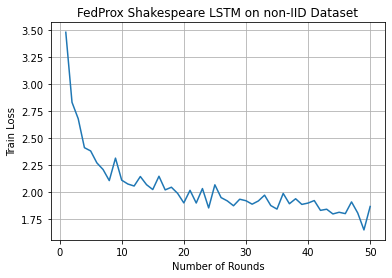

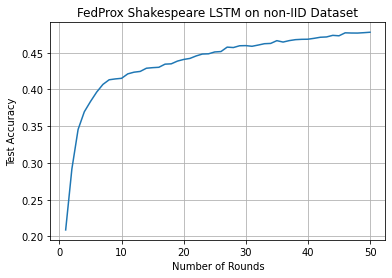

In [ ]:
# profiler = cProfile.Profile()
# profiler.enable()
mnist_cnn_non_iid_trained, test_history = training(shakespeare_lstm,
                                                   rounds, batch_size, lr,
                                                   None, #  ds empty as it is included in data_dict
                                                   data_dict,
                                                   test_ds,
                                                   C, K, E, mu, percentage,
                                                   "FedProx Shakespeare LSTM on non-IID Dataset", "green",
                                                   target_test_accuracy,
                                                   corpus, # classes
                                                   history=test_history,
                                                   #  tb_logger=tb_writer
                                                   )
# profiler.disable()

In [ ]:
testing(mnist_cnn_non_iid_trained, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(corpus), corpus)

running validation...



Test Loss: 1.768065


Final Test  Accuracy: 0.478 (24711.0/51704.0)


{'accuracy': 0.47793207488782297,
 'f1_macro': None,
 'f1_weighted': None,
 'loss': 1.7680654981875779}

In [ ]:
# stats = pstats.Stats(profiler).sort_stats('tottime')
# stats.print_stats()

#### qFedAvg

##### MNIST

In [ ]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10  # FedProx
# learning Rate
# lr = 0.01
lr = 0.03  # FedProx
# fairness
q = 0.001
# sampling
# sampling = 'uniform'
sampling = 'weighted'

In [ ]:
# dict containing different type of data partition
data_dict = non_iid_partition(dataset=mnist_data_train,
                              clients=K,
                              total_shards=200,
                              shards_size=300,
                              num_shards_per_client=2)

In [ ]:
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

In [ ]:
BASE_DIR = '/content/gdrive/MyDrive/FedPerf/mnist'
exp_name = f'model_r{rounds}_c{C}_r{E}_q{q}_{sampling}'
log_dir = f'{BASE_DIR}/{exp_name}'
tb_logger = SummaryWriter(log_dir)
print(f'TBoard logger created at: {log_dir}')
exp_name

test_history = []

In [ ]:
mnist_cnn_non_iid_trained, test_history = training(mnist_cnn,rounds, batch_size, lr,
                                                   mnist_data_train,
                                                   data_dict,
                                                   mnist_data_test,
                                                   C, K, E, q,
                                                   sampling=sampling,
                                                   tb_logger=tb_logger,
                                                   test_history=test_history,
                                                   perf_fig_file=f'{BASE_DIR}/loss.jpg'
                                                   )

In [ ]:
plot_scores(test_history, file=f'{BASE_DIR}/test_scores.jpg')

In [ ]:
plot_losses(test_history, file=f'{BASE_DIR}/test_loss.jpg')

In [ ]:
criterion = nn.CrossEntropyLoss()

test_scores = testing(model=mnist_cnn_non_iid_trained,
                      dataset=mnist_data_test,
                      bs=128,
                      criterion=criterion,
                      num_classes=num_classes,
                      classes=classes_test
                      )
test_scores

In [ ]:
tb_logger.add_hparams(hparam_dict={'rounds': rounds,
                                   'C': C,
                                   'K': K,
                                   'E': E,
                                   'batch_size': batch_size,
                                   'lr': lr,
                                   'q': q,
                                   'sampling': sampling
                                   },
                      metric_dict=test_scores,
                      run_name=exp_name)

In [ ]:
tb_logger.flush()
tb_logger.close()

##### Shakespeare

In [ ]:
seq_length = 80  # mcmahan17a, fedprox, qFFL
embedding_dim = 8  # mcmahan17a, fedprox, qFFL
hidden_dim = 100  # fedprox
# hidden_dim = 256  # mcmahan17a
num_classes = len(corpus)
classes = list(range(num_classes))
lstm_layers = 2  # mcmahan17a, fedprox, qFFL
dropout = 0.1  # TODO

In [ ]:
data_dict, test_ds = shakespeare_noniid_partition(corpus,
                                         seq_length=seq_length, 
                                         val_split=True)

total_clients = len(data_dict.keys())
'Total users:', total_clients

SKIP THE_TRAGEDY_OF_KING_LEAR_MOONSHINE 40
SKIP THE_TAMING_OF_THE_SHREW_ALL_SERVANTS 25
SKIP THE_TRAGEDY_OF_KING_LEAR_DESERVING_A_FAIR_LADY 2
SKIP THE_TAMING_OF_THE_SHREW_TIMANDRA 8
SKIP PERICLES__PRINCE_OF_TYRE_SECOND_MESSENGER 58
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_THIRD_DRAWER 52
SKIP THE_TAMING_OF_THE_SHREW_BANDITTI 12
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_GENTLEMAN 44
SKIP PERICLES__PRINCE_OF_TYRE_LOVEL 40
SKIP PERICLES__PRINCE_OF_TYRE_GHOST_OF_VAUGHAN 9
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_MICHAEL 28
SKIP THE_TRAGEDY_OF_KING_LEAR_LEONARDO 3
SKIP PERICLES__PRINCE_OF_TYRE_PRIEST 12
SKIP ALL_S_WELL_THAT_ENDS_WELL_TRIBUNE 10
SKIP PERICLES__PRINCE_OF_TYRE_ALL 55
SKIP ALL_S_WELL_THAT_ENDS_WELL_CITIZENS 31
SKIP ALL_S_WELL_THAT_ENDS_WELL_FRENCHMAN 32
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_FIRST_WARDER 46
SKIP MUCH_ADO_ABOUT_NOTHING_FIRST_GENTLEMAN 16
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_DENNY 31
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_TOWNSMAN 6

('Total users:', 122)

In [ ]:
# number of training rounds
rounds = 50
# client fraction
C = 0.07  # fedprox (10 clients per round)
# number of clients
K = total_clients
# number of training passes on local dataset for each roung
E = 1  # qFFL
# batch size
batch_size = 10  # fedprox
# learning Rate
lr = 0.8  # fedprox, qFFL
# fairness
q = 0.001  # qFFL
# sampling
# sampling = 'uniform'
sampling = 'weighted'

In [ ]:
shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=embedding_dim,  
                                   hidden_dim=hidden_dim,
                                   classes=num_classes,
                                   lstm_layers=lstm_layers,
                                   dropout=dropout,
                                   batch_first=True
                                   )

if torch.cuda.is_available():
    shakespeare_lstm.cuda()

In [ ]:
BASE_DIR = '/content/gdrive/MyDrive/FedPerf/shakespeare'
exp_name = f'model_r{rounds}_c{C}_r{E}_q{q}_{sampling}'
log_dir = f'{BASE_DIR}/{exp_name}'
tb_logger = SummaryWriter(log_dir)
print(f'TBoard logger created at: {log_dir}')
exp_name

test_history = []

TBoard logger created at: /content/gdrive/MyDrive/FedPerf/shakespeare/model_r50_c0.07_r1_q0.001_weighted


Round: 1 Picking 8/122 clients: [ 95   3 120 103  36  29  52  73]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)



Round: 1... 	Average Loss: 3.439
Round: 2 Picking 8/122 clients: [65 50 81 18 56 67 99 26]



Round: 2... 	Average Loss: 3.195
Round: 3 Picking 8/122 clients: [ 73  81   5  28   8 119 120  99]



Round: 3... 	Average Loss: 3.206
Round: 4 Picking 8/122 clients: [ 52  12  93  66  14  72   4 119]



Round: 4... 	Average Loss: 3.152
Round: 5 Picking 8/122 clients: [ 39  90  56  73  30 120  99 119]



Round: 5... 	Average Loss: 3.186


Error tensor(54, device='cuda:0') 0

Test Loss: 3.134872

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0


Round: 6... 	Average Loss: 3.151
Round: 7 Picking 8/122 clients: [102  56  48  73  18  99  11 121]



Round: 7... 	Average Loss: 3.195
Round: 8 Picking 8/122 clients: [ 99  34   2 102  95  10  56  14]



Round: 8... 	Average Loss: 3.12
Round: 9 Picking 8/122 clients: [111  81  56   8  95  83 119  72]



Round: 9... 	Average Loss: 3.177
Round: 10 Picking 8/122 clients: [14 95 99 75 72 73 64  3]



Round: 10... 	Average Loss: 3.141


Error tensor(54, device='cuda:0') 0

Test Loss: 3.129821

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0


Round: 11... 	Average Loss: 3.161
Round: 12 Picking 8/122 clients: [ 99  39  12  50  25 119  82 103]



Round: 12... 	Average Loss: 3.163
Round: 13 Picking 8/122 clients: [ 99  30 116  73 118  56  14  34]



Round: 13... 	Average Loss: 3.102
Round: 14 Picking 8/122 clients: [ 64 102 111   3  73  63  39  14]



Round: 14... 	Average Loss: 3.147
Round: 15 Picking 8/122 clients: [ 56 119  73  93 120  30  67  39]



Round: 15... 	Average Loss: 3.156


Error tensor(54, device='cuda:0') 0

Test Loss: 3.129984

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0


Round: 16... 	Average Loss: 3.163
Round: 17 Picking 8/122 clients: [ 18  72 121  39  90  99  95  56]



Round: 17... 	Average Loss: 3.168
Round: 18 Picking 8/122 clients: [ 82  73  12 103  56  30   5  89]



Round: 18... 	Average Loss: 3.177
Round: 19 Picking 8/122 clients: [92  3 73 39 88 29 93 56]



Round: 19... 	Average Loss: 3.12
Round: 20 Picking 8/122 clients: [119  18  56  14 114  39  90  99]



Round: 20... 	Average Loss: 3.132


Error tensor(54, device='cuda:0') 0

Test Loss: 3.127789

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0


Round: 21... 	Average Loss: 3.149
Round: 22 Picking 8/122 clients: [ 95 118 115  99  84  12  25 119]



Round: 22... 	Average Loss: 3.12
Round: 23 Picking 8/122 clients: [81  3 12 90  2 25 73 93]



Round: 23... 	Average Loss: 3.119
Round: 24 Picking 8/122 clients: [ 89  39  95  56  98 103  90  81]



Round: 24... 	Average Loss: 3.139
Round: 25 Picking 8/122 clients: [ 12  56  41  39 120  58 115  82]



Round: 25... 	Average Loss: 3.145


Error tensor(54, device='cuda:0') 0

Test Loss: 3.127455

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0


Round: 26... 	Average Loss: 3.165
Round: 27 Picking 8/122 clients: [ 88  29 119  56   3  71 120  99]



Round: 27... 	Average Loss: 3.138
Round: 28 Picking 8/122 clients: [ 50  56 103  28  73 119  93  80]



Round: 28... 	Average Loss: 3.173
Round: 29 Picking 8/122 clients: [ 12  81 121  18  73 114  97  93]



Round: 29... 	Average Loss: 3.176
Round: 30 Picking 8/122 clients: [ 93  56  50  99 112 119  73  66]



Round: 30... 	Average Loss: 3.148


Error tensor(54, device='cuda:0') 0

Test Loss: 3.125429

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0


Round: 31... 	Average Loss: 3.13
Round: 32 Picking 8/122 clients: [ 71  73  50  81   3   5 102  56]



Round: 32... 	Average Loss: 3.171
Round: 33 Picking 8/122 clients: [15 73 99 39 81 12  7 72]



Round: 33... 	Average Loss: 3.139
Round: 34 Picking 8/122 clients: [ 83  95 120  73  56  99  44  66]



Round: 34... 	Average Loss: 3.171
Round: 35 Picking 8/122 clients: [ 12   3 120 103  93  59  28  23]



Round: 35... 	Average Loss: 3.147


Error tensor(54, device='cuda:0') 0

Test Loss: 3.128072

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0


Round: 36... 	Average Loss: 3.138
Round: 37 Picking 8/122 clients: [ 63  39  56  99   3  14   5 117]



Round: 37... 	Average Loss: 3.139
Round: 38 Picking 8/122 clients: [93 72 12 28 65 58 82 89]



Round: 38... 	Average Loss: 3.149
Round: 39 Picking 8/122 clients: [  5  56  81  73 106  89  25   8]



Round: 39... 	Average Loss: 3.147
Round: 40 Picking 8/122 clients: [ 84   3  81 119  80  56  85  67]



Round: 40... 	Average Loss: 3.083


Error tensor(54, device='cuda:0') 0

Test Loss: 3.125837

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0


Round: 41... 	Average Loss: 3.146
Round: 42 Picking 8/122 clients: [ 12  93   8  56 103   3 102  48]



Round: 42... 	Average Loss: 3.138
Round: 43 Picking 8/122 clients: [ 14  93  82 114  95  99  48  29]



Round: 43... 	Average Loss: 3.11
Round: 44 Picking 8/122 clients: [ 99 121  62  56 119  97  63  90]



Round: 44... 	Average Loss: 3.192
Round: 45 Picking 8/122 clients: [ 99  12 119  73 102  56 118   3]



Round: 45... 	Average Loss: 3.147


Error tensor(54, device='cuda:0') 0

Test Loss: 3.121840

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0


Round: 46... 	Average Loss: 3.153
Round: 47 Picking 8/122 clients: [ 90  99  12  72   8  73  57 119]



Round: 47... 	Average Loss: 3.176
Round: 48 Picking 8/122 clients: [56 14 18 99 81 12 93  7]



Round: 48... 	Average Loss: 3.109
Round: 49 Picking 8/122 clients: [102  94  12 121  56  99 119 120]



Round: 49... 	Average Loss: 3.173
Round: 50 Picking 8/122 clients: [ 99  56  12  73  63 119  14  72]



Round: 50... 	Average Loss: 3.132


Error tensor(54, device='cuda:0') 0

Test Loss: 3.126501

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0

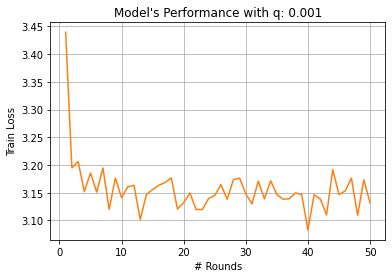

In [ ]:
shakespeare_lstm_non_iid_trained, test_history = training(shakespeare_lstm,
                                            rounds, batch_size, lr,
                                            None,  # ds empty as it is included in data_dict
                                            data_dict,
                                            test_ds,
                                            C, K, E, q,
                                            sampling=sampling,
                                            tb_logger=tb_logger,
                                            test_history=test_history,
                                            perf_fig_file=f'{BASE_DIR}/loss.jpg'
                                            )

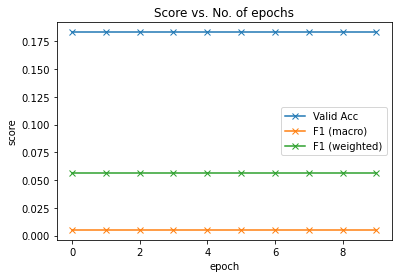

In [ ]:
plot_scores(test_history, file=f'{BASE_DIR}/test_scores.jpg')

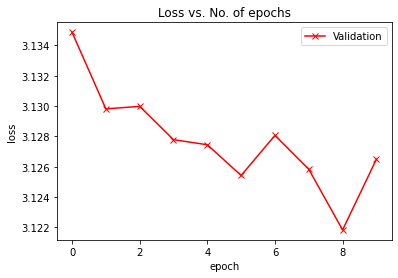

In [ ]:
plot_losses(test_history, file=f'{BASE_DIR}/test_loss.jpg')

In [ ]:
criterion = nn.CrossEntropyLoss()

test_scores = testing(model=shakespeare_lstm_non_iid_trained,
                      dataset=test_ds,
                      bs=batch_size,
                      criterion=criterion,
                      num_classes=num_classes,
                      classes=classes
                      )
test_scores

Error tensor(54, device='cuda:0') 0

Test Loss: 3.126501

F1 Score: 0.005158 (macro) 0.056649 (weighted) %

Test Accuracy of     0: 100% (1882/1882)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3:  0% ( 0/15)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5:  0% ( 0/75)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/73)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/137)
Test Accuracy of    10:  0% ( 0/ 7)
Test Accuracy of    11:  0% ( 0/18)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13:  0% ( 0/ 3)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15:  0% ( 0/85)
Test Accuracy of    16: N/A (no training examples)
Test Accuracy of    17: N/A (no training examples)
Test Accuracy of    18: N/A (no training examples)
Test Accuracy of    19:  0% ( 0/ 4)
Test Accuracy of    20:  0% ( 0

{'accuracy': 0.18307392996108948,
 'f1_macro': 0.005157718764559183,
 'f1_weighted': 0.05664912001692665,
 'loss': 3.1265007324597214}

In [ ]:
tb_logger.add_hparams(hparam_dict={'rounds': rounds,
                                   'C': C,
                                   'K': K,
                                   'E': E,
                                   'batch_size': batch_size,
                                   'lr': lr,
                                   'q': q,
                                   'sampling': sampling
                                   },
                      metric_dict=test_scores,
                      run_name=exp_name)

In [ ]:
tb_logger.flush()
tb_logger.close()